In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_matrix(rank, dims, seed=1):
    np.random.seed(seed)
    M_l = np.random.randn(dims[0], rank)
    M_r = np.random.randn(dims[1], rank)
    
    return M_l.dot(M_r.T)

In [4]:
def sampling_operator(nsamp, dims, seed=1):
    np.random.seed(seed)
    idx = np.random.choice(np.prod(dims), nsamp, replace=False)
    
    return np.vstack(np.unravel_index(idx, dims)).T

def sampling_matrix(Omega, M):
    P = np.zeros_like(M)
    for i in range(Omega.shape[0]):
        P[Omega[i][0], Omega[i][1]] = M[Omega[i][0], Omega[i][1]]
    return P

def complementary_sampling_matrix(Omega, M):
    P = M.copy()
    for i in range(Omega.shape[0]):
        P[Omega[i][0], Omega[i][1]] = 0
    return P

In [64]:
nsamp = 1000000
dims = (1000, 1000)
r = 5

Omega = sampling_operator(nsamp, dims)
M = get_matrix(r, dims)

b = np.zeros(nsamp)
for i in xrange(nsamp):
    b[i] = M[Omega[i][0], Omega[i][1]]

In [10]:
def clipping(A, mu):
    n, r = A.shape
    A = np.minimum(A, 2*mu*np.sqrt(r) / np.sqrt(n)*np.ones([n, r]))
    return np.linalg.qr(A)[0]

def V_update(U, Omega, M, dims):
    nsamp = Omega.shape[0]
    b = np.zeros(nsamp)
    for i in range(nsamp):
        b[i] = M[Omega[i][0], Omega[i][1]]
    r = U.shape[1]
    X = np.zeros([nsamp, dims[1]*r])
    print X.shape
    for i in range(nsamp):
        X[i, r*Omega[i][1]:r*(Omega[i][1]+1)] = U[Omega[i][0], :]
    return sc.linalg.lstsq(X, b)[0].reshape(r, dims[1], order='F')
    
def U_update(V, Omega, M, dims):
    nsamp = Omega.shape[0]
    b = np.zeros(nsamp)
    for i in range(nsamp):
        b[i] = M[Omega[i][0], Omega[i][1]]
    
    r = V.shape[0]
    X = np.zeros([nsamp, dims[0]*r])
    for i in range(nsamp):
        X[i, r*Omega[i][0]:r*(Omega[i][0]+1)] = V[:, Omega[i][1]]
    return sc.linalg.lstsq(X, b)[0].reshape(dims[0], r, order='C')

def RMSE(A, B):
    return 1. * np.linalg.norm(A - B, 'fro') / np.sqrt(np.prod(A.shape))

In [183]:
np.random.seed(1)

Omega_set = []
T = int(0.1 * nsamp)
ind = np.random.choice(2*T+1, nsamp)
p = .1
mu = 1.

#for i in range(2*T+1):
#    Omega_set.append(Omega[ind==i])

for i in range(2*T+1):
    Omega_set.append(Omega)
    
U = np.linalg.svd(1 / p * sampling_matrix(Omega_set[0], M))[0][:, :r]
U = clipping(U, mu)
print sc.linalg.norm(U)
for t in range(T):
    V = V_update(U, Omega_set[t+1], M, dims)
    U = U_update(V, Omega_set[T+t+1], M, dims)
    print np.linalg.norm(V), np.linalg.norm(U)

2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775
(200, 100)
25.6846671281 2.2360679775


In [5]:
from sklearn.metrics import mean_squared_error

mean_squared_error(M, U.dot(V))

NameError: name 'U' is not defined

In [185]:
from cvxpy import *

X = Variable(dims[0], dims[1])

objective = Minimize(norm(X, 'nuc'))

constraints = []
for i in range(Omega.shape[0]):
    constraints.append(X[Omega[i][0], Omega[i][1]] == M[Omega[i][0], Omega[i][1]])

prob = Problem(objective, constraints)

prob.solve()

prob.status

'optimal'

In [186]:
mean_squared_error(M, X.value)

5.8086636938764508e-31

In [60]:
from fancyimpute import SoftImpute, BiScaler

solver = SoftImpute(max_rank=r, convergence_threshold=1e-3, verbose=True, max_iters=100, normalizer=BiScaler(verbose=True))
X_incomplete = np.ones(M.shape)*np.nan
for i in range(Omega.shape[0]):
    X_incomplete[Omega[i][0], Omega[i][1]] = M[Omega[i][0], Omega[i][1]]

X_filled = solver.complete(X_incomplete)

[BiScaler] Initial log residual value = 8.493281
[BiScaler] Iter 1: log residual = 0.594023, log improvement ratio=7.899258
[BiScaler] Iter 2: log residual = -3.454575, log improvement ratio=4.048598
[BiScaler] Iter 3: log residual = -7.015416, log improvement ratio=3.560841
[BiScaler] Iter 4: log residual = -9.980939, log improvement ratio=2.965524
[BiScaler] Iter 5: log residual = -12.835324, log improvement ratio=2.854385
[BiScaler] Iter 6: log residual = -15.666362, log improvement ratio=2.831038
[BiScaler] Iter 7: log residual = -18.487126, log improvement ratio=2.820764
[BiScaler] Iter 8: log residual = -21.300249, log improvement ratio=2.813122
[BiScaler] Iter 9: log residual = -24.106899, log improvement ratio=2.806651
[BiScaler] Iter 10: log residual = -26.908016, log improvement ratio=2.801117
[BiScaler] Iter 11: log residual = -29.704436, log improvement ratio=2.796420
[BiScaler] Iter 12: log residual = -32.496897, log improvement ratio=2.792461
[BiScaler] Iter 13: log resid

In [61]:
RMSE(M, X_filled)

0.28199081207205345

In [63]:
X_filled[:5, :5]

array([[-0.27926792,  2.3349199 ,  1.39760426, -2.08971976,  0.47593492],
       [ 4.57058432, -2.26702245, -3.2548627 ,  2.96379147,  0.41959177],
       [-2.35737006,  2.66669843,  2.20362521, -4.2539124 , -1.01237477],
       [ 2.14622961, -0.05299796, -0.87642554, -0.74359455, -0.33217207],
       [ 1.29652932, -0.0630515 , -3.77011213,  3.01356671, -1.11739165]])

In [58]:
M[:5, :5]

array([[-0.27926792,  1.84705982,  0.983686  , -2.08971976,  0.42235195],
       [ 4.57058432, -2.26702245, -3.48910735,  3.42664198,  0.82451254],
       [-2.32849772,  2.06136609,  2.20362521, -4.61906102, -1.1021358 ],
       [ 2.14622961, -0.73523926, -1.19027235, -0.68424094, -0.18948317],
       [ 1.48993398, -0.54299834, -3.88061845,  3.34583123, -0.8270505 ]])

In [13]:
summ = 0
for i in range(Omega.shape[0]):
    summ += (X_filled[Omega[i][0], Omega[i][1]] - M[Omega[i][0], Omega[i][1]])**2
summ

0.0

In [ ]:

RMSE(M, X_filled)

In [49]:
from fancyimpute import IterativeSVD

solver = IterativeSVD(r)
X_incomplete = np.ones(M.shape)*np.nan
for i in range(Omega.shape[0]):
    X_incomplete[Omega[i][0], Omega[i][1]] = M[Omega[i][0], Omega[i][1]]

X_filled = solver.complete(X_incomplete)

[IterativeSVD] Iter 1: observed MAE=2.465167
[IterativeSVD] Iter 2: observed MAE=2.286439
[IterativeSVD] Iter 3: observed MAE=2.000273
[IterativeSVD] Iter 4: observed MAE=1.557169
[IterativeSVD] Iter 5: observed MAE=1.199482
[IterativeSVD] Iter 6: observed MAE=0.979937
[IterativeSVD] Iter 7: observed MAE=0.835587
[IterativeSVD] Iter 8: observed MAE=0.731921
[IterativeSVD] Iter 9: observed MAE=0.653871
[IterativeSVD] Iter 10: observed MAE=0.591553
[IterativeSVD] Iter 11: observed MAE=0.540862
[IterativeSVD] Iter 12: observed MAE=0.498787
[IterativeSVD] Iter 13: observed MAE=0.463179
[IterativeSVD] Iter 14: observed MAE=0.432280
[IterativeSVD] Iter 15: observed MAE=0.405997
[IterativeSVD] Iter 16: observed MAE=0.382997
[IterativeSVD] Iter 17: observed MAE=0.362615
[IterativeSVD] Iter 18: observed MAE=0.344401
[IterativeSVD] Iter 19: observed MAE=0.327855
[IterativeSVD] Iter 20: observed MAE=0.312603
[IterativeSVD] Iter 21: observed MAE=0.298494
[IterativeSVD] Iter 22: observed MAE=0.2855

In [50]:
RMSE(X_filled, M)

3.1716884822743752

In [62]:
Z_old = np.zeros_like(M)
tol = 1e-3
max_iters = 40

lamb_array = np.logspace(2, -2, 40)

for lamb in lamb_array:
    for k in range(max_iters):
        S_lamb = sampling_matrix(Omega, M) + complementary_sampling_matrix(Omega, Z_old)
        U, D, V = sc.linalg.svd(S_lamb)
        D_thresh = np.maximum(D - lamb, 0)
        rank = (D_thresh > 0).sum()
        Z_new = U[:, :rank].dot(np.diag(D_thresh[:rank])).dot(V[:rank, :])
        if (np.linalg.norm(Z_old - Z_new) / np.max([np.linalg.norm(Z_old), 1e-6])) < tol:
            break
        Z_old = Z_new.copy()
    summ = 0
    for i in range(Omega.shape[0]):
        summ += (Z_new[Omega[i][0], Omega[i][1]] - M[Omega[i][0], Omega[i][1]])**2

    print summ, 
    print RMSE(Z_new, M)

153219.19245 5.53039945437
142576.961687 5.38423128789
122260.260221 5.09330392523
101235.277419 4.77093212273
80852.1292801 4.43731492912
62988.7205807 4.12027833687
48111.6737198 3.82898850183
36169.5266368 3.56538602185
27053.2859228 3.33823566404
20044.5988711 3.1449079569
14783.1876564 2.98280259014
10852.2421408 2.85117700089
7939.07564384 2.74624659046
5777.11844874 2.66397327602
4187.1980208 2.60249543667
3025.11865799 2.55546211334
2178.28799095 2.52162211435
1563.72941465 2.49765563939
1120.40325456 2.48099240338
800.131766219 2.46957930834
570.127557335 2.46181200089
404.6649691 2.45611601888
288.509794425 2.45240482425
204.668099576 2.44969812056
146.283531144 2.44800779609
103.717024976 2.44675722716
73.4478036023 2.44585636876
52.7303432112 2.44533628453
37.6455961272 2.44495286382
26.8069231862 2.44467844772
18.9823088559 2.44447869062
13.408222316 2.44433533082
9.45765599172 2.44423320011
6.66875049094 2.4441607254
4.69724565181 2.44410873709
3.39999512998 2.44408628346

In [60]:
summ = 0
for i in range(Omega.shape[0]):
    summ += (Z_new[Omega[i][0], Omega[i][1]] - M[Omega[i][0], Omega[i][1]])**2

summ

9.3936185132236828e-05

In [52]:
from scipy import misc

lena = misc.imread('lena512.jpg').astype('float64')

nsamp = int(0.2*np.prod(lena.shape))
r = 20

U, S, V = np.linalg.svd(lena)
lena_trunc = U[:, :r].dot(np.diag(S[:r])).dot(V[:r, :])

Omega = sampling_operator(nsamp, lena.shape)

from fancyimpute import SoftImpute, BiScaler

solver = SoftImpute(max_rank=r, convergence_threshold=1e-7, verbose=False, max_iters=500, normalizer=BiScaler(verbose=False))
X_incomplete = np.ones(lena.shape)*np.nan
for i in range(Omega.shape[0]):
    X_incomplete[Omega[i][0], Omega[i][1]] = lena_trunc[Omega[i][0], Omega[i][1]]

X_filled = solver.complete(X_incomplete)

In [53]:
RMSE(lena_trunc, X_filled)

5.429507172734759

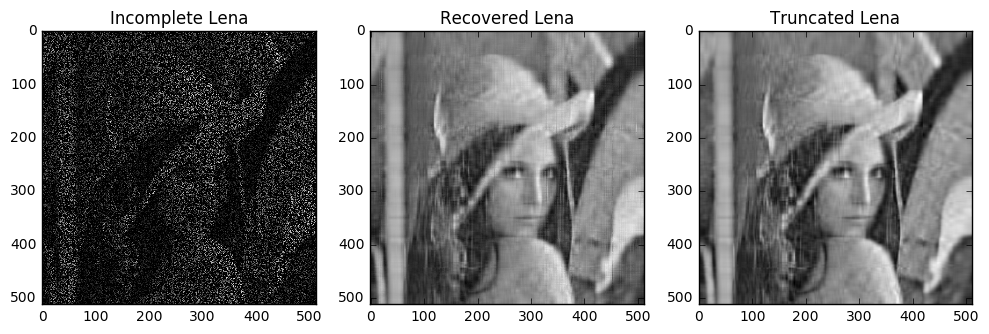

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].imshow(sampling_matrix(Omega, lena), cmap='gray')
ax[0].set_title('Incomplete Lena')
ax[1].imshow(X_filled, cmap='gray')
ax[1].set_title('Recovered Lena')
ax[2].imshow(lena_trunc, cmap='gray')
ax[2].set_title('Truncated Lena')
plt.show()

In [ ]:
def RMSE(X, Y):
    return np.sqrt(1. / np.prod(X.shape) * np.sum((X-Y)**2))

def MAE(X, Y):
    return 1. / np.prod(X.shape) * np.sum(np.abs(X-Y))

In [66]:
import sys

sys.path.append('./../helper_funcs')

from errors import *

NameError: name 'M' is not defined